# House Price: Advanced Regression Techniques

# Copyright: Fengping Wang

# 1. Load Data and Quick View

In [267]:
import os
# print(os.listdir("../input"))
from subprocess import check_output 
print(check_output(['ls', '../input']).decode('utf8'))

data_description.txt
sample_submission.csv
test.csv
train.csv



In [227]:
# f = open("../input/data_description.txt", "r") 
# print(f.read())

In [268]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn import ensemble, tree, linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import shuffle

In [269]:
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')

In [270]:
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')

In [271]:
print('original train dataset size', df_train.shape)
print('original test dataset size', df_test.shape)

original train dataset size (1460, 81)
original test dataset size (1459, 80)


In [272]:
print('train dataset columns \n', df_train.columns)

train dataset columns 
 Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       '

In [273]:
df_train.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [274]:
df_test.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal


# 2. Data Exploration 

# 2.1 Analyze Target: "SalePrice"

'SalePrice' is the variable we need to predict. So let's do some analysis on this variable first.

In [275]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

It seems that your minimum price is larger than zero. Excellent! And also there is no missing values here, which means all records are kind of valid here. I mean, at least, they all get a valid response variable. let's explore more here. 

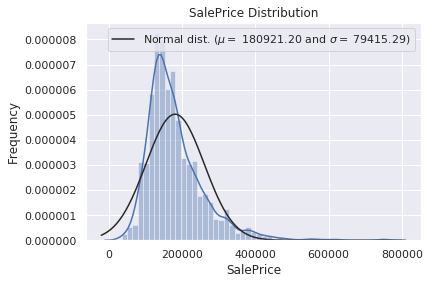

In [276]:
from scipy import stats 
from scipy.stats import norm, skew
sns.distplot(df_train['SalePrice'], fit = norm);
(mu, sigma) = norm.fit(df_train['SalePrice'])
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)], loc = 'best')
plt.ylabel('Frequency')
plt.title('SalePrice Distribution')
plt.show()

It seems like our distribution deviates from the normal distribution. Then let's  explore about the shape of the distribution using skewness and kurtosis.   
Skewness is the degree of distortion from the normal distribution. A symmetrical dataset will have a skewness equal to 0.  It measures the lack of symmetry in data distribution.    
Kurtosis is used to describe the extreme values in one versus the other tail. Kurtosis of the normal distribution is 3. It is actually the measure of outliers present in the distribution.

In [277]:
print('Skewness: %f' %df_train['SalePrice'].skew())
print('Kurtosis: %f' %df_train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


# 2.2 Analyze Relationships among 'SalePrice' and predictive variables

We will explore the relationships in about 3 steps, it's a wide-narrow approach:   
1. Correlation matrix (heatmap style): heatmap is the best way to get a quick overview of all varibles and relationships.  Each cell in the table shows the correlation between two variables. 
Correlation refers to the statistical relationship between two variables. A correlation could be positive, meaning both variables move in the same direction, or negative, meaning that when one variable's value increases, the other variables' values decrease.  
We can use correlation matrix to detect multicollinearity of predictive variables and also take a quick view of relationships between 'SalePrice' and all predictive variables. 
2. 'SalePrice' correlation matrix (heatmap style): We focus on variables most correlated with 'SalePrice'.   
3. Scatter plots between the most correlated variables. 

# 2.2.1 Correlation Matrix 

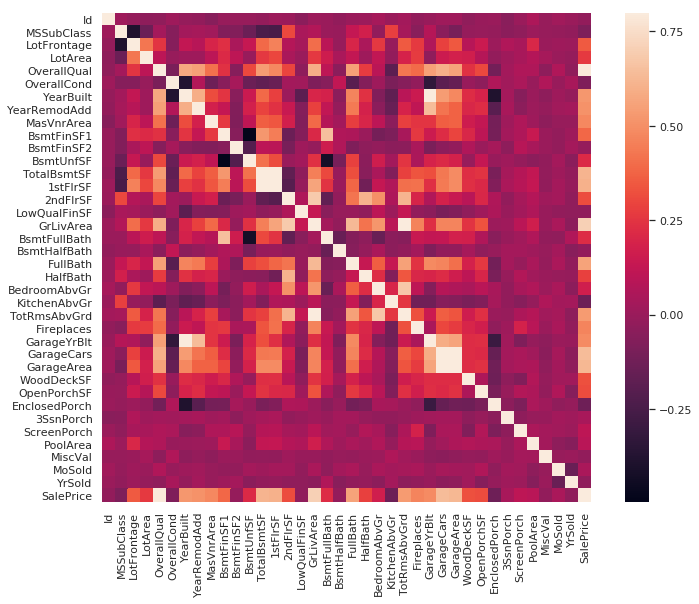

In [278]:
#correlation matrix
corrmat = df_train.corr()
f, ax = plt.subplots(figsize = (12, 9))
sns.heatmap(corrmat, vmax = 0.8, square = True);

At first singht, there are 2 white colored squrares drawing my attention. The first one is "TotalBsmtSF" and "1stFlrSF" variables, and the second one refers to Garage_related variables('GarageYrBlt', 'GarageCars', 'GarageArea'). Both cases indicates that these variables get significant corrleation, which also makes me suspect that there may exists multicolinearity. Well, we can conclude that they give almost the same information when multicollinearity really occurs. Heapmaps are really good to detect multicolinearity, wihich gives a clue for feature selection.  
If we focus on the SalePrice line, we can see that 'GrLivArea', 'TotalBsmtSF', and 'OverallQual' are outstanding here. But we still need to take other vairables into account. That is our next step. 

# 2.2.2 "SalePrice" Correlation Matrix

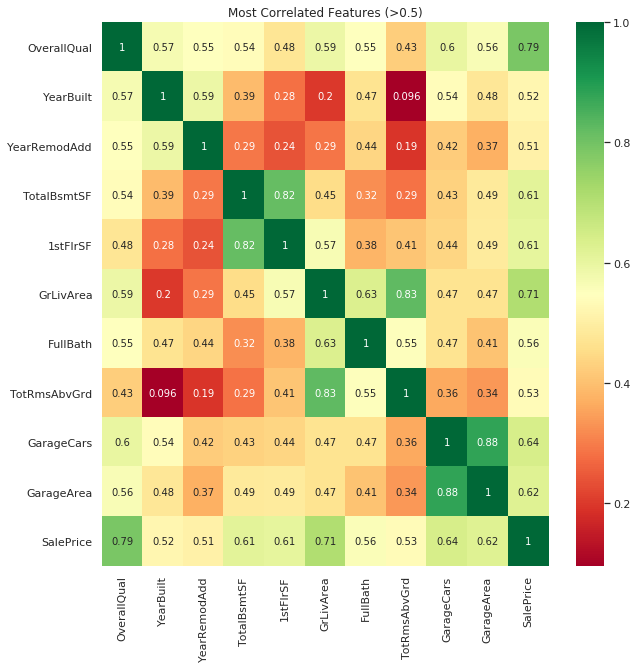

In [279]:
# most correlated features
corrmat = df_train.corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"]) > 0.5]
plt.figure(figsize = (10, 10))
g = sns.heatmap(df_train[top_corr_features].corr(), annot = True, cmap = 'RdYlGn');
plt.title("Most Correlated Features (>0.5)");

 According to our crystal ball, these are the variables most correlated with 'SalePrice'. 'OverallQual', 'GrLivArea' and 'TotalBsmtSF' are strongly correlated with 'SalePrice'.
 1. 'GarageCars' and 'GarageArea' are also some of the most strongly correlated variables. However, it's easy to understand since that the number of cars that fit into the garage is a consequence of the garage area. 'GarageCars' and 'GarageArea' are like twin brothers. You'll never be able to distinguish them. Therefore, we just need one of these variables in our analysis.
 2. 'TotalBsmtSF' and '1stFloor' also seem to be the same as the pair of 'GarageCars' and 'GarageArea'. We can only keep 'TotalBsmtSF' in our analysis. 
 3. 'TotRmsAbvGrd' and 'GrLivArea', seems to be twin brothers again.
 Ok, let's proceed to scatter plots between  'SalePrice' and correlated variables to explore more. 

# 2.2.3 Scatter Plots

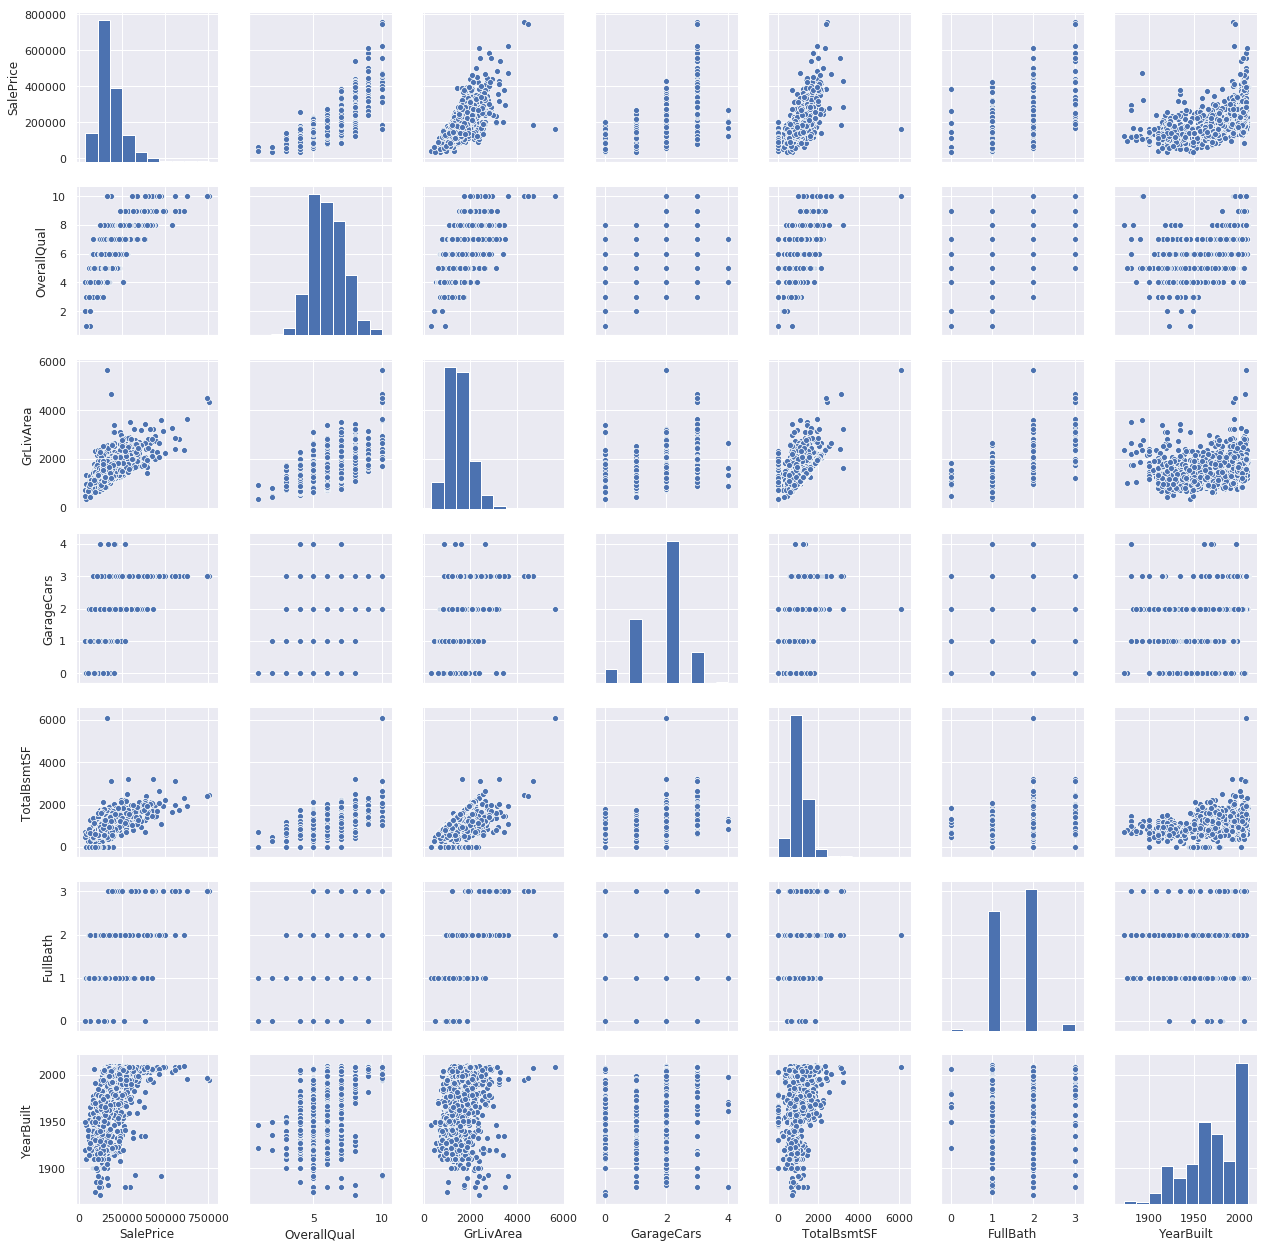

In [280]:
# scatter plots 
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea','GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], size = 2.5)
plt.show();

The scatter plots give us more detials aobut variable relationships. 
1. One interesting point is that the dots between 'TotalBsmtSF' and 'GrLiveArea' almost draws a linear line, which might also a trouble marker. But it makes sense that the basement areas can be equal to the above ground living area. Also most of dots stay above the slope = 1 line, that becasue a basement area usually smaller than the above ground living area in real life.
2. Let's foucs on the relationships between "SalePrice" and other variables.  For these 5 variables, 'OverallQual', 'GrLivArea',  'TotalBsmtSF', 'FullBath' and 'GarageCars', te relationships are kind of clear and obvious. But we still need to explore more for 'YearBuilt'.

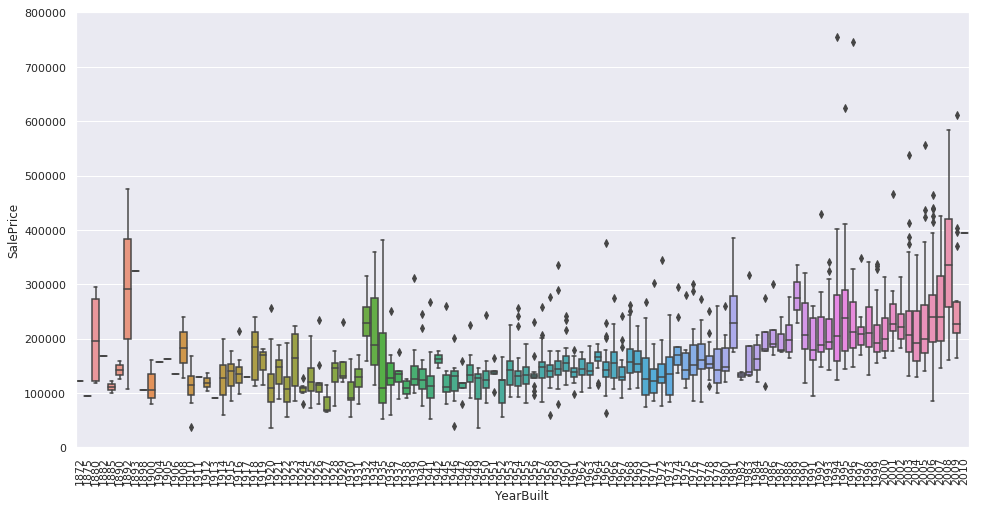

In [281]:
# box plot YearBuilt/saleprice
var = 'YearBuilt'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis = 1)
f, ax = plt.subplots(figsize = (16, 8))
fig = sns.boxplot(x = var, y = "SalePrice", data = data)
fig.axis(ymin = 0, ymax = 800000);
plt.xticks(rotation = 90);

Although it's not a strong tendency, I'd say that 'SalePrice' is more prone to spend more money in new stuff than in old relics.

# 3. Data Cleaning

For data cleaning, we will focus on 2 aspects: missing data and outliers. 

# 3.1 Missing Data

When talking about missing data, we need to think about 2 questions: 
1. How prevalent is the missing data?
2. Is missing data random or does it have a pattern?  

These 2 reasons are important since missind data can imply a reduction of the sample size. But when we throw out data, we need to ensure that the missing data process is not biased and hidding an truth. 

In [282]:
total = df_train.isnull().sum().sort_values(ascending = False)
percent = (df_train.isnull().sum() / df_train.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
missing_data_true = missing_data[missing_data['Total'] > 0]
corr = df_train.corr()["SalePrice"]
missing_percent_corr = pd.concat([missing_data_true, corr], axis = 1, join_axes = [missing_data_true.index])
missing_percent_corr = missing_percent_corr.rename(columns = {'SalePrice':'Corelation'})
missing_percent_corr

,Total,Percent,Corelation
PoolQC,1453,0.995205,NaN
MiscFeature,1406,0.963014,NaN
Alley,1369,0.937671,NaN
Fence,1179,0.807534,NaN
FireplaceQu,690,0.472603,NaN
LotFrontage,259,0.177397,0.351799
GarageCond,81,0.055479,NaN
GarageType,81,0.055479,NaN
GarageYrBlt,81,0.055479,0.486362
GarageFinish,81,0.055479,NaN


My thoughts on missing data above. Here I will delete the variable if it has missing data portion > 15% or it get low correlation with 'SalsPrice' but high correlation with existing variabes. Moreover, if we have variables with only one or two missing observation, we sometimes can just delete the missing observations instead. 
1. Variables with Missing Precentage > 15%  
Usually, we consider that when more than 15% of the data is missing, we should delete the corresponding variable. And we will not try any trick to fill the missing data in these cases. According to this, there is a set of variables (e.g. 'PoolQC', 'MiscFeature', 'Alley', etc.) that we should delete. But the point is: will we miss any information if we just delete this date? So I put the its correlation to "SalePrice" to third column. We can see that none of these variables seem to be very important. So we can safely delete them.
2. 'GarageX' variables and 'BsmtX' variables  
Next we move to remaining cases, we can see that 'GarageX' variables have the same number of missing data. It's nautrual to bet that these missing data refers to the same set of observations . Since the most important information regarding garages is expressed by 'GarageCars' and considering that we are just talking about 5% of missing data, we can delete the'GarageX' variables. The same logic applies to 'BsmtX' variables.  
3.  'MasVnrX' variables  
Regarding 'MasVnrArea' and 'MasVnrType', we can consider that these variables are not essential considering the correlation. Furthermore, they have a strong correlation with 'YearBuilt' and 'OverallQual' which are already considered. So no information will lose after deletion. 
4. 'Electrical' variable  
We have one missing observation in 'Electrical'. Since it is just one observation, we'll delete this observation and keep the variable.

In [283]:
print('Dataset size Before removing observaions and columns with Missing records', df_train.shape)
df_train = df_train.drop((missing_data[missing_data['Total'] > 1]).index, 1)
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)
print('Dataset size After removing observaions and columns with Missing records', df_train.shape)
print('Number of observaions with Missing records', df_train.isnull().sum().max())

Dataset size Before removing observaions and columns with Missing records (1460, 81)
Dataset size After removing observaions and columns with Missing records (1459, 63)
Number of observaions with Missing records 0


# 3.2 Outlier

Outliers is also something that we should always be aware of.  Outliers can markedly affect our models. It is a trouble marker but also can be a valuable source of information, providing us insights about specific behaviours.  
Here, we'll just do a quick analysis of Univariate analysis of 'SalePrice' and Bivariate analysis of 'SalePrice' vs predictive variables .

# 3.2.1 Univarate Analysis 

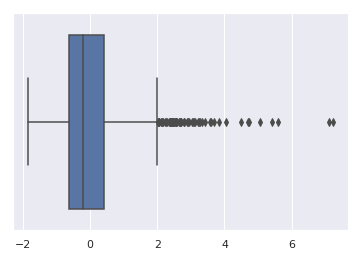

In [284]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
saleprice_scaled = scaler.fit_transform(df_train['SalePrice'][:,np.newaxis])
sns.boxplot(saleprice_scaled);

In [285]:
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10,:]
high_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][-20:, :]
print('10 Lowest Outliers')
print(low_range)
print('\n 20 largest Outliers')
print(high_range)

10 Lowest Outliers
[[-1.83820775]
 [-1.83303414]
 [-1.80044422]
 [-1.78282123]
 [-1.77400974]
 [-1.62295562]
 [-1.6166617 ]
 [-1.58519209]
 [-1.58519209]
 [-1.57269236]]

 20 largest Outliers
[[3.08489782]
 [3.13524919]
 [3.22530263]
 [3.24577046]
 [3.26112763]
 [3.33994012]
 [3.41155236]
 [3.57582371]
 [3.59470548]
 [3.70170215]
 [3.82758058]
 [4.0395221 ]
 [4.49473628]
 [4.70872962]
 [4.728631  ]
 [5.06034585]
 [5.42191907]
 [5.58987866]
 [7.10041987]
 [7.22629831]]


Here, we can see that the low range values are similar and not too far from 0. I would  say that I will keep all these low range ones. But for high range values, there are 2 values really far from 0, like 7. But we can see that we still have 5 and 4 something. It's a trend like increase gradually, so I will not consider these two 7 something as outliers. 

# 3.2.2 Bivariate Analysis

Now we go back and take a look at our scatter plots between 'SalePrice' and correlated variables before from a different perspective. We notice that among all the top-correlated variable, there are obvious dots that out of trend in plot "SalePrice VS GrLivArea" and "SalePrice VS  TotalBsmtSF". There should be something to discover.

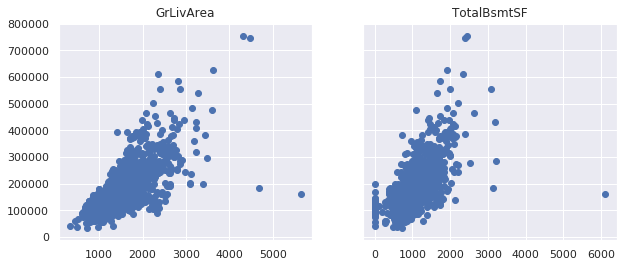

In [286]:
# bivariate analysis saleprice/grlivarea and saleprice/TotalBsmtSF
f, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize=(10,4))
ax1.scatter(df_train['GrLivArea'], df_train['SalePrice']);
ax1.set_title('GrLivArea')
ax2.scatter(df_train['TotalBsmtSF'], df_train['SalePrice']);
ax2.set_title('TotalBsmtSF')
plt.show()

1. The plot of  "SalePrice VS GrLivArea"   
There are two values with bigger 'GrLivArea' seem strange and not following the crowd. I'm not sure about what is happening but I'm quite confident that these two points are not representative of the typical case. Therefore, we'll define them as outliers and delete them.
2. The plot of  "SalePrice VS TotalBsmtSF"     
* There is one dot with bigger 'TotalBsmtSF' out of trend. Same logic here and we will treat it as outlier and delete it. 

In [287]:
# deleting Outlier 
print('Dataset size Before removing observaions with Outliers', df_train.shape)
outlier_GrLivArea = df_train.sort_values(by = 'GrLivArea', ascending = False)[:2]
outlier_TotalBsmtSF = df_train.sort_values(by = 'TotalBsmtSF', ascending = False)[:1]
outlier = pd.concat([outlier_GrLivArea, outlier_TotalBsmtSF], axis = 1)
df_train = df_train[~df_train.index.isin(outlier.index)]
print('Dataset size After removing observaions with Outliers', df_train.shape)

Dataset size Before removing observaions with Outliers (1459, 63)
Dataset size After removing observaions with Outliers (1457, 63)


One interesting point is the outlier in 'TotalBsmtSF' plot is one of the two outliers in the 'GrLivArea' plots. So here we just need to remove two outliers instead of three.

# 4. Assumptions Testing 

To apply multivariate analysis, we need to prepare our data to comply statistical assumptions. There are 4 assumptions we need to test.   
1. Normality   
Our data should look like a normal distribution whichseveral statistic tests relies on. If we solve normality, we avoid a lot of other problems (e.g. heteroscedacity). Here we will check univariate normality for 'SalePrice' and predictive variables and do a log transformation if necessary. 
2. Homoscedasticity(homogeneity of variance)  
Homoscedasticity refers to the 'assumption that dependent variables exhibit equal levels of variance across the range of predictor variables' . Homoscedasticity is desirable because we want the error term to be the same across all values of the independent variables. Here we will use a scatter plot to check it's the dispersion. 
3. Linearity    
The most common way to assess linearity is to examine scatter plots and search for linear patterns. If patterns are not linear, it would be worthwhile to explore data transformations. However, we'll not get into this because most of the scatter plots we've seen appear to have linear relationships.  
4. Absence of correlated errors   
Correlated errors happen when one error is correlated to another. For instance, if one positive error makes a negative error systematically indicating a  rrelationship between these variables. This occurs often in time series, where some patterns are time related.  The bast way to solve it is to add a variable that can explain the effect you're getting. However, unitll there is no indication of correlated errors.


# 4.1 Normality 

'SalePrice' is the variable we need to predict, so let's do analysis on this first. 


 mu = 180942.14 and sigma = 79494.28



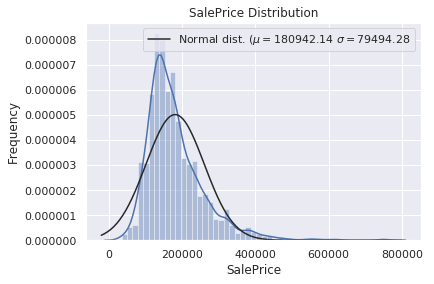

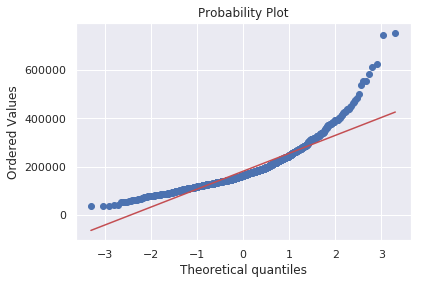

In [290]:
from scipy import stats 
from scipy.stats import norm, skew
sns.distplot(df_train['SalePrice'], fit = norm);
(mu, sigma) = norm.fit(df_train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=${:.2f} $\sigma=${:.2f}'.format(mu, sigma)], loc = 'best')
plt.ylabel('Frequency')
plt.title('SalePrice Distribution')
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot = plt)
plt.show()

Here, 'SalePrice' is not normal. It shows 'peakedness', positive skewness and does not follow the diagonal line. Well, everything's not lost. A simple data transformation can solve the problem. In case of positive skewness, log transformations usually works well.

In [291]:
df_train['SalePrice'] = np.log(df_train['SalePrice'])

In [292]:
# differentiate numerical features and categorical features
categorical_features = df_train.select_dtypes(include = ['object']).columns
numerical_features = df_train.select_dtypes(exclude = 'object').columns
numerical_features.drop('SalePrice')
print('Categorical features: ', str(len(categorical_features)))
print('Numerical features: ', str(len(numerical_features)))

Categorical features:  28
Numerical features:  35


In [293]:
df_train_num = df_train[numerical_features]
df_train_cat = df_train[categorical_features]

In [294]:
from scipy.stats import skew 
skewness = df_train_num.apply(lambda x: skew(x))
skewness.sort_values(ascending = False)


MiscVal          24.426546
PoolArea         15.927003
LotArea          12.556596
3SsnPorch        10.282886
LowQualFinSF      8.992490
KitchenAbvGr      4.478508
BsmtFinSF2        4.245879
ScreenPorch       4.113045
BsmtHalfBath      4.094248
EnclosedPorch     3.082631
OpenPorchSF       2.336612
WoodDeckSF        1.543785
MSSubClass        1.406525
GrLivArea         1.009196
BsmtUnfSF         0.918998
1stFlrSF          0.886145
2ndFlrSF          0.813404
BsmtFinSF1        0.763177
OverallCond       0.689307
HalfBath          0.681432
TotRmsAbvGrd      0.660262
Fireplaces        0.630414
BsmtFullBath      0.588647
TotalBsmtSF       0.511928
MoSold            0.214262
BedroomAbvGr      0.212374
OverallQual       0.199349
GarageArea        0.130911
SalePrice         0.121426
YrSold            0.095574
FullBath          0.032539
Id                0.000822
GarageCars       -0.341318
YearRemodAdd     -0.500385
YearBuilt        -0.610969
dtype: float64

In [295]:
skewness = skewness[abs(skewness) > 0.5]
skewness.sort_values(ascending = False).index

Index(['MiscVal', 'PoolArea', 'LotArea', '3SsnPorch', 'LowQualFinSF',
       'KitchenAbvGr', 'BsmtFinSF2', 'ScreenPorch', 'BsmtHalfBath',
       'EnclosedPorch', 'OpenPorchSF', 'WoodDeckSF', 'MSSubClass', 'GrLivArea',
       'BsmtUnfSF', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'OverallCond',
       'HalfBath', 'TotRmsAbvGrd', 'Fireplaces', 'BsmtFullBath', 'TotalBsmtSF',
       'YearRemodAdd', 'YearBuilt'],
      dtype='object')

In [296]:
skew_features = df_train[skewness.index]
skew_features = np.log(skew_features)

In [297]:
print('Categorical features shape before dummy feature creation: \n', df_train_cat.shape)
df_train_cat = pd.get_dummies(df_train_cat)
print('Create dummy features for categorical values via one-hot encoding: \n', df_train_cat.shape)

Categorical features shape before dummy feature creation: 
 (1457, 28)
Create dummy features for categorical values via one-hot encoding: 
 (1457, 186)


In [298]:
df_train = pd.concat([df_train_cat,df_train_num],axis = 1)

# 4.2 Homoscedasticity

The best approach to test homoscedasticity for two metric variables is graph. Departures from an equal dispersion are shown by such shapes as cones (small dispersion at one side of the graph, large dispersion at the opposite side) or diamonds (a large number of points at the center of the distribution). Let's look at our scatterplots. 

In [299]:
print("Find most important features relative to target")
corr = df_train.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice[:11])

Find most important features relative to target
SalePrice       1.000000
OverallQual     0.821589
GrLivArea       0.725226
GarageCars      0.681053
GarageArea      0.656157
TotalBsmtSF     0.648154
1stFlrSF        0.620761
FullBath        0.596021
YearBuilt       0.587301
YearRemodAdd    0.566208
TotRmsAbvGrd    0.537716
Name: SalePrice, dtype: float64


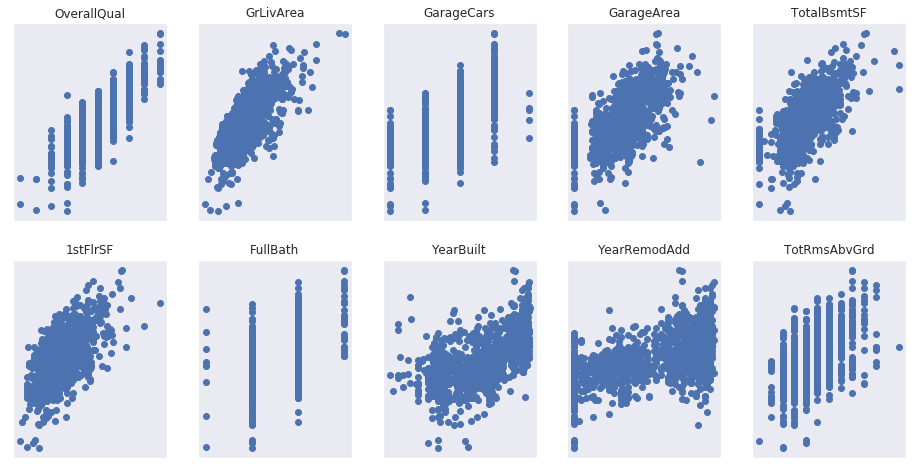

In [300]:
cols = corr.SalePrice[1:11].index
var = 'SalePrice'

n_row = 2
n_col = 5
plt.figure(figsize = (16, 8))
for i in range(n_row * n_col):  
    plt.subplot(n_row, n_col, i + 1)
    plt.scatter(df_train[cols[i]], df_train[var])
    plt.title(cols[i])
    plt.xticks(())
    plt.yticks(())
plt.show()

Older versions of this scatter plot, the scatter plot before log transformations, had a conic shape (check 'Scatter plots between 'SalePrice' and correlated variables'). However, the current one doesn't have that conic shape anymore. Usually, normality and homoscedasticity go hand by hand. So by ensuring normality, we can solve the homoscedasticity problem as well.

# Modeling 

In [185]:
test = df_train['SalePrice']
train = df_train.drop(['SalePrice'], axis = 1)
print('Overall Train(df_train) Dataset Shape: ', df_train.shape)
print('Response Variables(train) Dataset Shape: ', train.shape)
print('Predictive Variables(test) Dataset Shape: ', test.shape)

Overall Train(df_train) Dataset Shape:  (1457, 221)
Response Variables(train) Dataset Shape:  (1457, 220)
Predictive Variables(test) Dataset Shape:  (1457,)


# split train and test dataset

In [194]:
X_train, X_test, Y_train, Y_test = train_test_split(train, test, 
                                                    test_size = 0.15, 
                                                    random_state = 42)

In [195]:
print('X_train Dataset Shape: ', X_train.shape)
print('Y_train Dataset Shape: ', Y_train.shape)
print('X_test Dataset Shape: ', X_test.shape)
print('Y_test Dataset Shape: ', Y_test.shape)

X_train Dataset Shape:  (1238, 220)
Y_train Dataset Shape:  (1238,)
X_test Dataset Shape:  (219, 220)
Y_test Dataset Shape:  (219,)


# Build a simple linear model 

First, We create a Linear Regression model and get a quick a look of our model.

The root-mean-square error (RMSE) is a frequently used measure of the differences between values predicted by a model and the values observed. The RMSE represents the square root of the second sample moment of the differences between predicted values and observed values. In other words, RMSE is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are; RMSE is a measure of how spread out these residuals are. So, it tells you how concentrated the data is around the line of best fit.

# K-fold Cross Validation

Now, we split our dataset into 2 parts, train(X_train, X_test) and test(X_test , Y_test) with ratio of 85% and 15%. But in reality, it has one major disadvantage with this simple partation. For example, What if the split we make isn’t random enough? What if one subset of our data has only people from a certain state, like certain income level, or certian sex?  This will result in overfitting, even though we’re trying to avoid it! Since we are not certain which data points will end up in the train/test sets and the result might be entirely two different sets. Thus, it is a good choice only if we have enough data. To address this problem, we need to hire Cross Validation.   
Cross-validation is a statistical technique which involves partitioning the data into subsets, training the data on a subset and use the other subset to evaluate the model’s performance. Cross-validation will give us a more accurate estimate of a model’s performance.  
One fo the most famous Cross Validation is k-Fold Cross-Validation. This procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. As such, the procedure is often called k-fold cross-validation.   
The general procedure is as follows:  
1. Shuffle the dataset randomly.  
2. Split the dataset into k groups.   
3. For each unique group:  
    ---Take the group as a hold out or test data set  
    ---Take the remaining groups as a training data set  
    ---Fit a model on the training set and evaluate it on the test set  
    ---Retain the evaluation score and discard the model  
4. Summarize the skill of the model using the sample of model evaluation scores  

Importantly, each observation in the data sample is assigned to an individual group and stays in that group for the duration of the procedure. This means that each sample is given the opportunity to be used in the hold out set 1 time and used to train the model k-1 times.  
The choice of k is usually 5 or 10, but there is no formal rule. A value of k=10 is very common in the field of applied machine learning, and is recommend if you are struggling to choose a value for your dataset.  

For example, if we have 3 folders here, and the procedure will be:   
Model1: Trained on Fold1 + Fold2, Tested on Fold3  
Model2: Trained on Fold2 + Fold3, Tested on Fold1  
Model3: Trained on Fold1 + Fold3, Tested on Fold2  
The models are then discarded after they are evaluated as they have served their purpose. But the skill scores are collected for each model and summarized for use.

In [ ]:
# Here, to same time we use k = 5
n_folder = 5
from sklearn.metrics import make_scorer
from sklearn.selection import KFold 
scorer = make_scorer(mean_squared_error, greater_is_better = False)
def rmse_CV_train(model):
    kf = KFold(n_folder, shuffle = True, random_state = 25).get_n_splits(train.values)